# 08/26/20 - Writing and testing PSF and noise map generator for KiDS imaging.

In [9]:
# libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.stats import sigma_clip as clip
import autolens as al
import autolens.plot as aplt

In [2]:
# set datapaths
links_path = '/home/shawn/Desktop/links_autoz/'
fits_path = f'{links_path}files/fits/'
fits_image_path = f'{fits_path}images/'
csv_path = f'{links_path}files/csv/'
png_path = f'{links_path}visuals/png/'
pdf_path = f'{links_path}visuals/pdf/'

In [3]:
# import LinKS candidates that are in autoz
links = pd.read_csv(f'{csv_path}links_autoz_sample_latest.csv')
links_ids = links[ ['GAMA_ID','ID'] ].sort_values('ID')
links_ids.to_csv(f'{csv_path}links_ids_list.csv')

## Need to determine pixel scale. I don't believe I've been able to find it in the data from the fits file. Maybe I'm just not looking closely enough.
## Petrillo-18 says it's 101x101 pixels (20x20 arcsec)
## I take that to mean that the pixel scale is 20/101 or 0.198 arcsec per pixel.
## Average PSF is 0.65... How many pixels is that? that's 2$\sigma$ of the Gaussian? Divide by 2? That gives us sigma_psf?

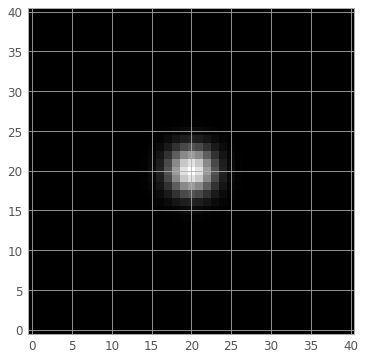

In [3]:
# from astropy tutorial
size = 20  # on each side from the center
sigma_psf = 2.0
y, x = np.mgrid[-size:size+1, -size:size+1]
psf = np.exp(-(x**2 + y**2)/(2.0*sigma_psf**2))
psf /= np.sum(psf)
plt.imshow(psf, origin='lower', cmap='gray')

In [5]:
avg_psf = 0.65 # arcsec
avg_psf_pxl = 0.65/0.198 # pixels
sigma_psf = avg_psf_pxl/2 # = 1.64
sigma_psf

1.6414141414141414

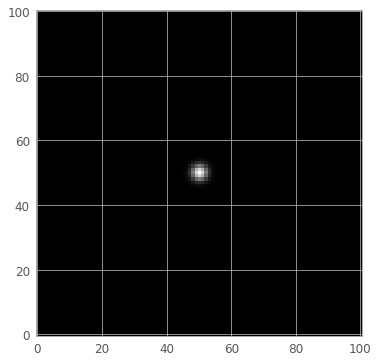

In [6]:
# let's try to make this work...
size = 50 # gives a grid of 101 (50 on either side of the center)
y, x = np.mgrid[-size:size+1, -size:size+1]
psf = np.exp(-(x**2 + y**2)/(2.0*sigma_psf**2))
psf /= np.sum(psf)
plt.imshow(psf, origin='lower', cmap='gray')

## Woo! I think I got it :)

In [8]:
# 08/27/20 - finishing it up by saving as a fits file
hdu = fits.PrimaryHDU(psf)
#hdu.writeto(f'{fits_image_path}links/G262874_26/G262874_26_psf.fits')

OSError: File '/home/shawn/Desktop/links_autoz/files/fits/images/links/G262874_26/G262874_26_psf.fits' already exists.

# 09/03/20 - Edit: According to Autolens preprocess tutorial 3, PSF size should been 21x21.

# 08/27/20 - Noise map generator

In [49]:
# we're going to use G262874 (LinKS 26) to test this out
G262874_r = fits.open(f'{fits_image_path}links/G262874_26/G262874_26_r.fits')
G262874_g = fits.open(f'{fits_image_path}links/G262874_26/G262874_26_g.fits')
print(G262874_r.info())
print(G262874_g.info())
G262874_r[0].header

Filename: /home/shawn/Desktop/links_autoz/files/fits/images/links/G262874_26/G262874_26_r.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      85   (101, 101)   float32   
None
Filename: /home/shawn/Desktop/links_autoz/files/fits/images/links/G262874_26/G262874_26_g.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      85   (101, 101)   float32   
None


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  101 / Number of pixels along this axis               
NAXIS2  =                  101 / Number of pixels along this axis               
EXTEND  =                    T / This file may contain FITS extensions          
OBJECT  = 'KIDS_221.6_2.5'                                                      
ZEROPNT =                  0.0                                                  
ZPNTERR =                  0.0                                                  
CREADATE= '2017-07-13T12:55:46.000'                                             
PSF_RAD =   0.5682767391204834                                                  
INSTRUME= 'OMEGACAM'                                                            
TELESCOP= 'ESO-VLT-U0'      

(101, 101)
(101, 101)


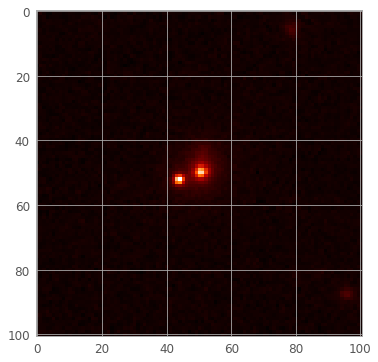

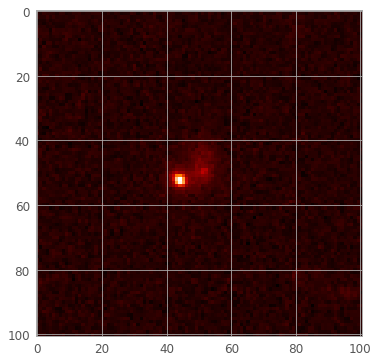

In [19]:
# image file is in extenstion 0
G262874_r_image = G262874_r[0].data
G262874_g_image = G262874_g[0].data
print(G262874_r_image.shape)
print(G262874_g_image.shape)
# plot
plt.figure()
plt.imshow(G262874_r_image)
plt.figure()
plt.imshow(G262874_g_image)

## Looks to me like the r-band is the better one.

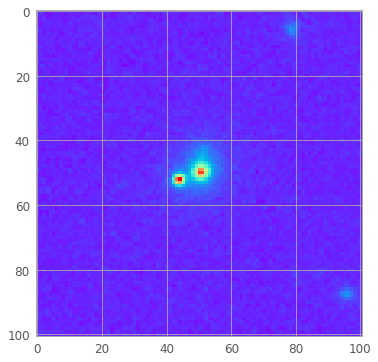

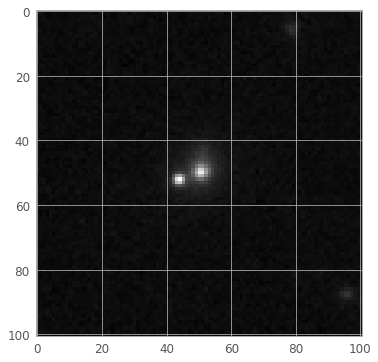

In [20]:
# see it in greyscale/rainbow/whatever
plt.figure()
plt.imshow(G262874_r_image, cmap = 'rainbow')
plt.figure()
plt.imshow(G262874_r_image, 
           cmap = 'gray')

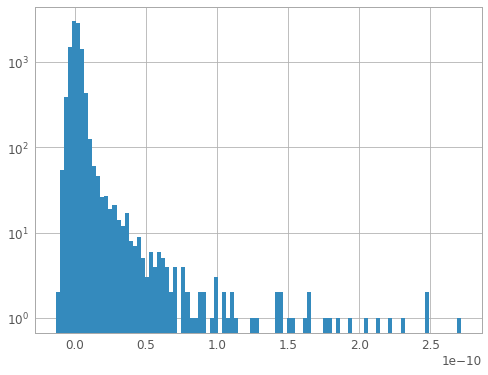

In [21]:
# plot signal in histogram
a=plt.hist(np.ravel(G262874_r_image),bins=100,log=True)

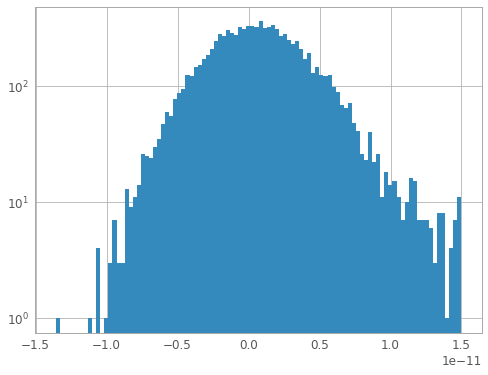

In [22]:
# the Gaussian is going to be the noise
sky = np.where(G262874_r_image<1.5*10**-11)

a=plt.hist(np.ravel(G262874_r_image[sky]),bins=100,log=True)

In [32]:
# find mean and std of this gaussian
print(G262874_r_image[sky].mean(), G262874_r_image[sky].std())

8.0170056e-13 3.641136e-12


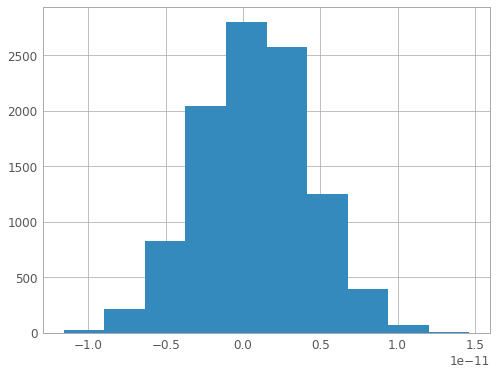

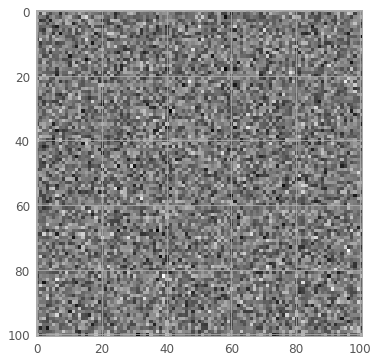

In [42]:
# generate array from this distribution
from numpy import random

mean = G262874_r_image[sky].mean()
std = G262874_r_image[sky].std()
#y, x = np.mgrid[0:size1, 0:size2]

skyimage = np.random.normal(loc=mean,
                            scale=std,
                            size= (101, 101)
                           )

a=plt.hist(np.ravel(skyimage))
plt.show()

b=plt.figure()
plt.imshow(skyimage, cmap='gray')

### This procedure will work. Unfortunately I can't see how I will automate it. I'll have to figure out the sigma clipping idea that Benne talked about. It should be fairly easy to find the peak and cut the gaussian that way. SExtractor for Dummies supposedly has the presciption

### 08/28/20 - Trying to automate the identification of the peak for sigma clipping.

In [33]:
# how does the mean and std of the whole distribution compare to the cut sky
print(G262874_r_image[sky].mean(), G262874_r_image[sky].std())
print(G262874_r_image.mean(), np.median(G262874_r_image), G262874_r_image.std())
# they are an order of magnitude off

8.0170056e-13 3.641136e-12
2.113751e-12 7.922577e-13 1.1435753e-11


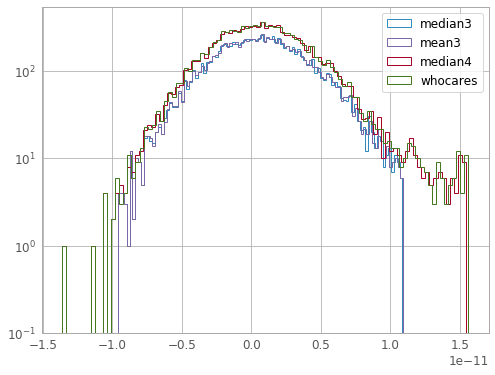

In [45]:
# clip
clipped_median_3sigma=clip(G262874_r_image, cenfunc='median')
clipped_mean_3sigma=clip(G262874_r_image, cenfunc='mean')
clipped_median_4sigma=clip(G262874_r_image, sigma=4, cenfunc='median')
clipped_mean_4sigma=clip(G262874_r_image, sigma=4, cenfunc='mean')
a=plt.hist(np.ravel(clipped_median_3sigma),
           bins=100,
           log=True,
           histtype='step',
          label='median3')
b=plt.hist(np.ravel(clipped_mean_3sigma),
           bins=100,
           log=True,
           histtype='step',
          label='mean3')
c=plt.hist(np.ravel(clipped_median_4sigma),
           bins=100,
           log=True,
           histtype='step',
          label='median4')
d=plt.hist(np.ravel(clipped_mean_4sigma),bins=100,log=True,histtype='step',label='whocares')
plt.legend()

### It appears that the 3-sigma clip is fine. Mean and median result in very similar results. I'll do median because it is more likely to be closer to the mean of the Gaussian part of the distribution.
### Now to write the script.

In [129]:
def get_noisey(folder, file): # insert fits file path (f'{fits_image_path}links/G262874_26/G262874_26_r.fits')
    
    # get the file ready
    hdul = fits.open(f'{folder}{file}') # open the fits
    print(f'Gettin noisey with {hdul[0].header[6]}') # list object name
    print(hdul.info())
    image = hdul[0].data # select first HDU to be the image
    
    # plot image data
    plt.figure()
    plt.title = (f'{hdul[0].header[6]}')
    plt.imshow(image)#, cmap='gray') # show image in grayscale
    plt.show()
    #
    plt.figure()
    plt.title = (f'{hdul[0].header[6]} signal')
    plt.hist(np.ravel(image),bins=100,log=True) # plot signal in histogram
    plt.show()
    print(f'Mean {np.mean(image)}, Median {np.median(image)}')
    
    # clip to 3sigma around median
    print('Clipping to 3-sigma about median value')
    clipped_image=clip(image, cenfunc='median')
    plt.figure()
    plt.title=(f'{hdul[0].header[6]} noise')
    plt.hist(np.ravel(clipped_image),bins=100,log=True) # plot signal in histogram
    plt.show()
    
    # generate Gaussian noise about mean and std
    mean = clipped_image.mean()
    std = clipped_image.std()
    noise_map = np.random.normal(loc=mean,
                                scale=std,
                                size= image.shape
                                )
    
    # plot noise map
    plt.figure() # show histogram of signal values
    plt.hist(np.ravel(noise_map))
    plt.show()
    plt.figure() # show noise map image
    plt.title=(f'Noise Map for {hdul[0].header[6]}')
    plt.imshow(noise_map, cmap='gray')
    
    # write to fits file
    hdu = fits.PrimaryHDU(noise_map)
    hdu.writeto(f'{folder}{file[:-5]}_noisemap.fits')
    print(f'Image sent to {folder}{file[:-5]}_noisemap.fits')
    
    # good vibes
    print('Congratulations! You simulated random noise! Eat a cookie.')
    
    
#get_noisey(f'{fits_image_path}links/G262874_26/G262874_26_r.fits') # it works!

Gettin noisey with KIDS_221.6_2.5
Filename: /home/shawn/Desktop/links_autoz/files/fits/images/links/G262874_26/G262874_26_r.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      85   (101, 101)   float32   
None


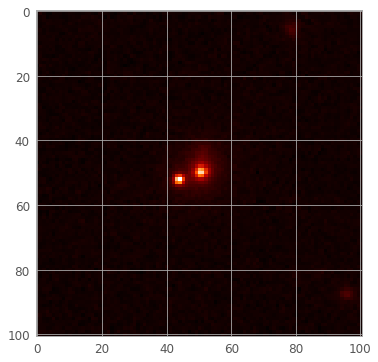

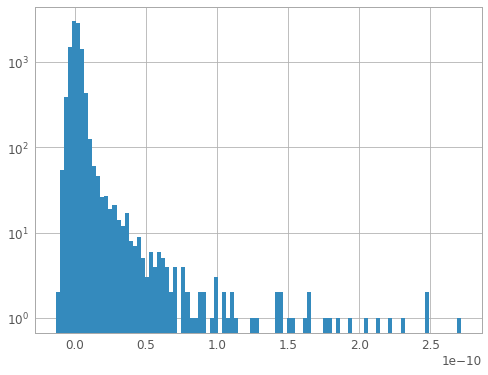

Mean 2.1137510144986216e-12, Median 7.92257698247617e-13
Clipping to 3-sigma about median value


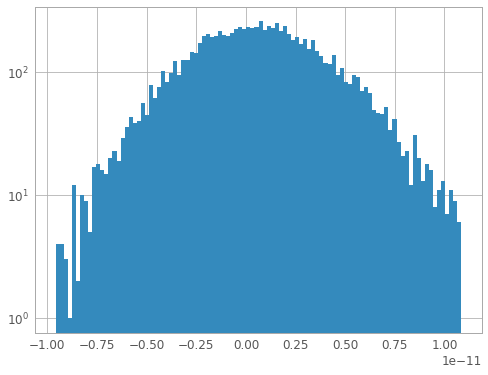

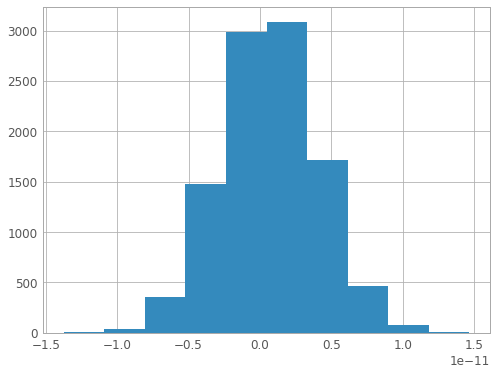

OSError: File '/home/shawn/Desktop/links_autoz/files/fits/images/links/G262874_26/G262874_26_r_noisemap.fits' already exists.

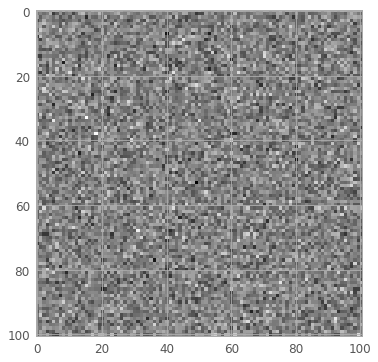

In [130]:
folder = f'{fits_image_path}links/G262874_26/'
file = 'G262874_26_r.fits'

get_noisey(folder, file)

# It works! Now I just need to figure out an easy way to feed in the files.